# Data Augmentation

Found 252 files belonging to 13 classes.
Using 202 files for training.
Found 252 files belonging to 13 classes.
Using 50 files for validation.


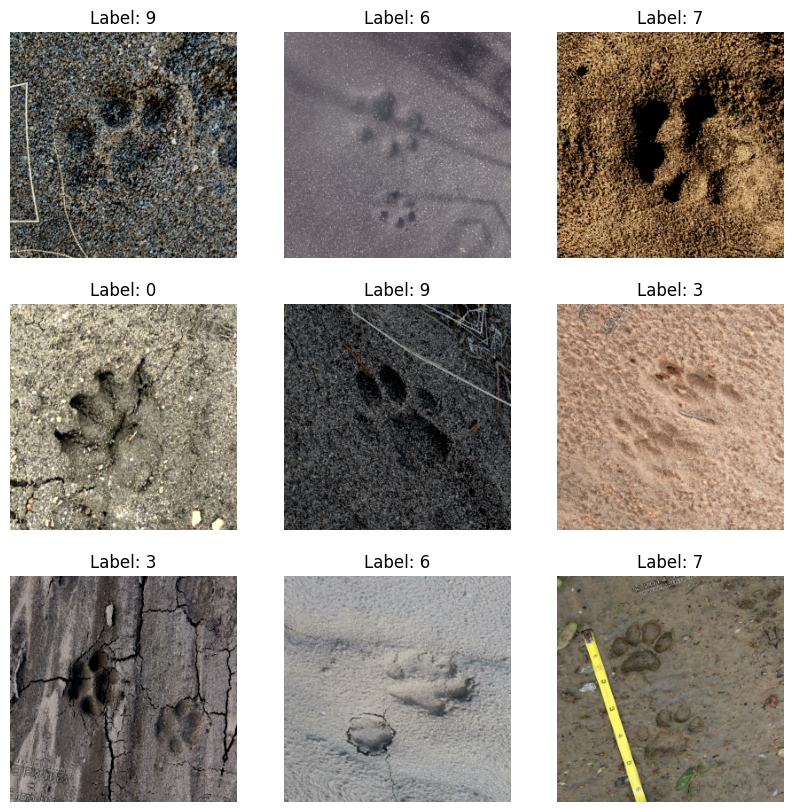

In [13]:
from keras import Sequential
import numpy as np
import tensorflow as tf
from keras.api.utils import Sequence
from keras.api.preprocessing import image_dataset_from_directory
from keras.api.layers import RandomFlip, RandomRotation, RandomBrightness, RandomContrast, Rescaling
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

batch_size = 32
image_width, image_height, input_channel = (256, 256, 3)

# Charger les datasets
train_ds = image_dataset_from_directory(
    "/home/shared/Mammiferes_jpg",
    batch_size=None, # Laisser None pour faire le batching dans le générateur
    image_size=(image_width, image_height),
    validation_split=0.2,
    subset="training",
    seed=42
)
val_ds = image_dataset_from_directory(
    "/home/shared/Mammiferes_jpg",
    batch_size=None,
    image_size=(image_width, image_height),
    validation_split=0.2,
    subset="validation",
    seed=42
)

# Définition des couches d'augmentation aléatoire des données
augmentation_layers = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
    Rescaling(1.0/255)
])

# Classe de génération de données
class WildlensDataGenerator(Sequence):
    def __init__(self, dataset, batch_size, input_size=(image_width, image_height, input_channel), shuffle=True):
        super().__init__()
        self.dataset = list(dataset.as_numpy_iterator())
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))
        self.on_epoch_end()

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        # Implémentation de la récupération d'un batch de données
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.dataset))
        batch_indexes = self.indexes[start:end]

        # Récupérer les données du batch
        batch = [self.dataset[i] for i in batch_indexes]
        x_batch, y_batch = zip(*batch)
        x_batch = np.array(list(x_batch))
        y_batch = np.array(list(y_batch))

        # Appliquer les couches d'augmentation aléatoire
        x_batch = augmentation_layers(x_batch, training=True)

        return x_batch, y_batch

    def visualize_batch(self, index):
        x_batch, y_batch = self.__getitem__(index)
        plt.figure(figsize=(10, 10))
        for i in range(min(len(x_batch), 9)):
            plt.subplot(3, 3, i + 1)
            plt.imshow(x_batch[i])
            plt.title(f"Label: {y_batch[i]}")
            plt.axis("off")
        plt.show()

# Instanciation du générateur
train_generator = WildlensDataGenerator(train_ds, batch_size=batch_size, shuffle=True)

# Visualisation d'un batch après augmentation
train_generator.visualize_batch(0)